<a href="https://colab.research.google.com/github/nupoorsagar/Denoising_ECG/blob/main/wavelet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyWavelets
!pip install wfdb matplotlib numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 122.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.


Percent Root-mean-square Difference (PRD): 1.21%
Output Signal-to-Noise Ratio (SNR): 32.90 dB


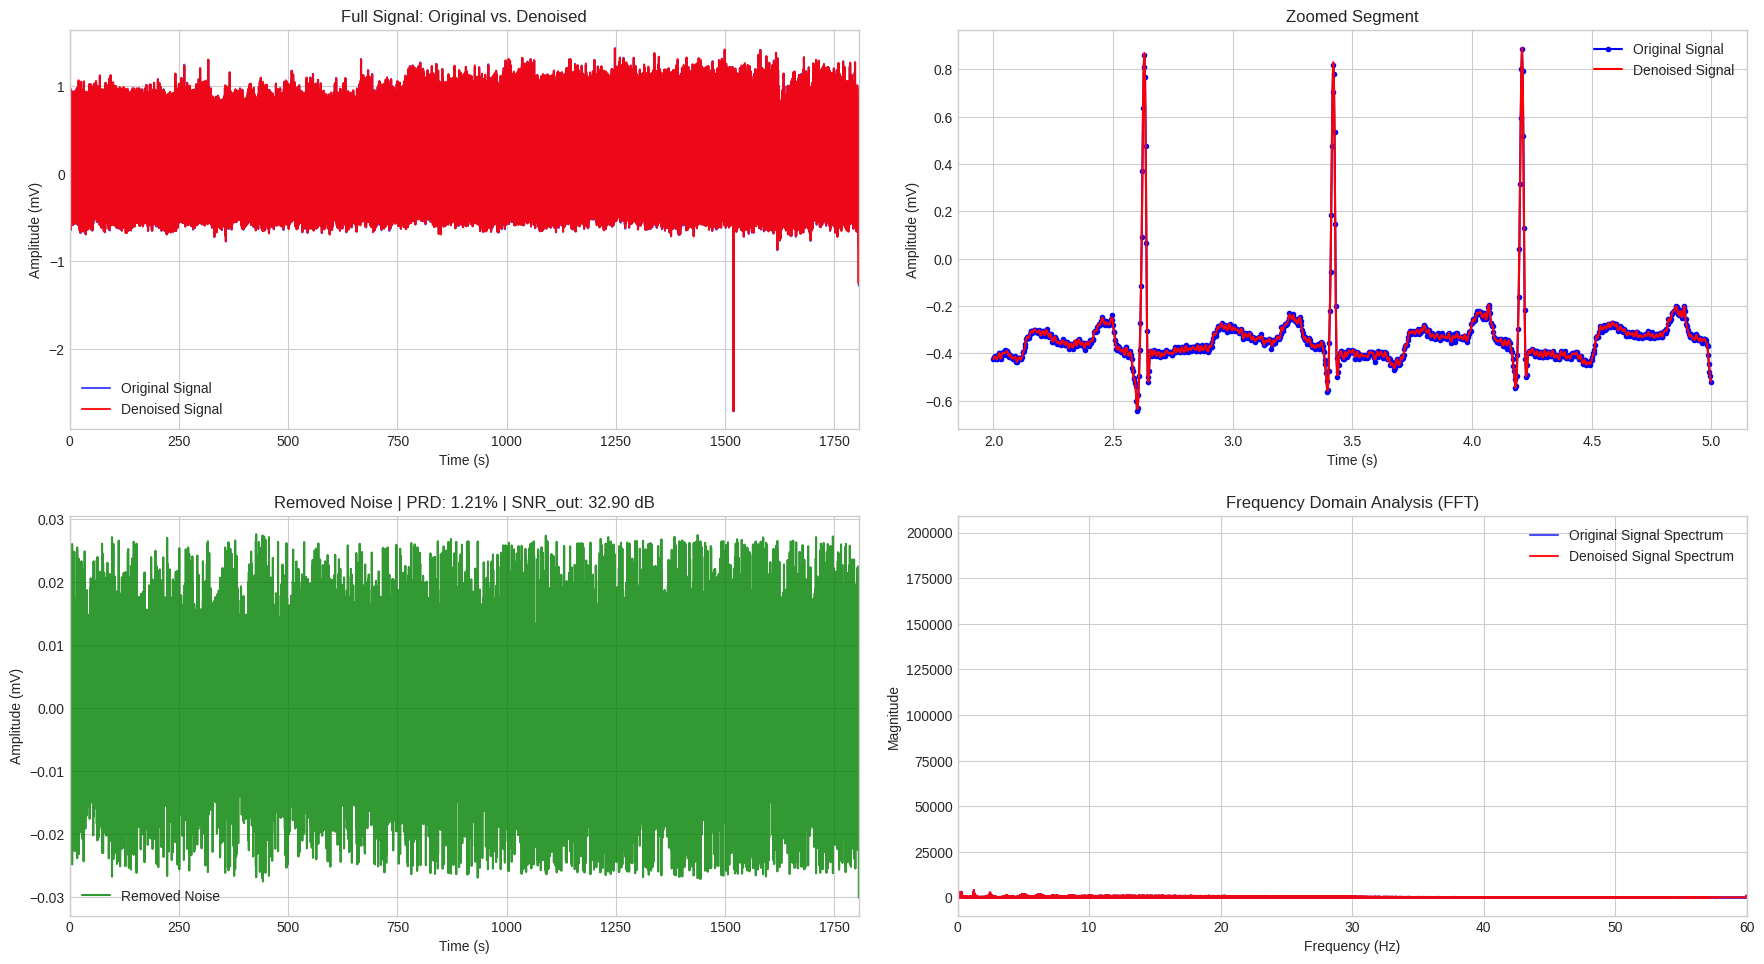

In [ ]:
import pywt
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft

# 1. Load a record from the MIT-BIH Arrhythmia Database
record_name = '100'
record = wfdb.rdrecord(record_name, pn_dir='mitdb/1.0.0/')

# 2. Extract the ECG signal and sampling frequency
signal = record.p_signal[:, 0]
fs = record.fs
time = np.arange(len(signal)) / fs # Create a time axis in seconds

# 3. Wavelet Denoising Function (same as before)
def wavelet_denoising(signal, wavelet='sym8', level=1):
    coeffs = pywt.wavedec(signal, wavelet, mode='per', level=level)
    sigma = (1/0.6745) * np.median(np.abs(coeffs[-1] - np.median(coeffs[-1])))
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs_thresholded = [coeffs[0]] + [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs[1:]]
    denoised_signal = pywt.waverec(coeffs_thresholded, wavelet, mode='per')
    return denoised_signal

# 4. Apply denoising and prepare signals
denoised_signal = wavelet_denoising(signal, wavelet='sym8', level=1)
min_len = min(len(signal), len(denoised_signal))
signal = signal[:min_len]
denoised_signal = denoised_signal[:min_len]
time = time[:min_len]
removed_noise = signal - denoised_signal

# 5. Function to calculate PRD (same as before)
def calculate_prd(original_signal, denoised_signal):
    numerator = np.sum((original_signal - denoised_signal) ** 2)
    denominator = np.sum(original_signal ** 2)
    return np.sqrt(numerator / denominator) * 100 if denominator != 0 else np.inf

# 6. NEW: Function to calculate SNR
def calculate_snr(signal_component, noise_component):
    """
    Calculates the Signal-to-Noise Ratio (SNR) in decibels (dB).
    """
    # Calculate the power of the signal and noise (variance is a good proxy for power)
    power_signal = np.var(signal_component)
    power_noise = np.var(noise_component)

    if power_noise == 0:
        return np.inf # Infinite SNR if there is no noise

    snr_db = 10 * np.log10(power_signal / power_noise)
    return snr_db

# Calculate metrics
prd_value = calculate_prd(signal, denoised_signal)
# We treat the denoised signal as our "true signal" and the removed part as "noise"
snr_output = calculate_snr(denoised_signal, removed_noise)

print(f"Percent Root-mean-square Difference (PRD): {prd_value:.2f}%")
print(f"Output Signal-to-Noise Ratio (SNR): {snr_output:.2f} dB")

# --- Plotting Section (2x2 Grid) ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Plot 1: Full Segment Comparison
axs[0, 0].plot(time, signal, label='Original Signal', color='blue', alpha=0.7)
axs[0, 0].plot(time, denoised_signal, label='Denoised Signal', color='red', alpha=0.9)
axs[0, 0].set_title('Full Signal: Original vs. Denoised')
axs[0, 0].set_xlabel('Time (s)')
axs[0, 0].set_ylabel('Amplitude (mV)')
axs[0, 0].legend()
axs[0, 0].set_xlim([time[0], time[-1]])

# Plot 2: Zoomed Segment Comparison
zoom_start_time, zoom_end_time = 2, 5
start_idx, end_idx = int(zoom_start_time * fs), int(zoom_end_time * fs)
axs[0, 1].plot(time[start_idx:end_idx], signal[start_idx:end_idx], label='Original Signal', color='blue', marker='.', linestyle='-')
axs[0, 1].plot(time[start_idx:end_idx], denoised_signal[start_idx:end_idx], label='Denoised Signal', color='red')
axs[0, 1].set_title('Zoomed Segment')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('Amplitude (mV)')
axs[0, 1].legend()

# Plot 3: Removed Noise and Metrics
title_str = f'Removed Noise | PRD: {prd_value:.2f}% | SNR_out: {snr_output:.2f} dB'
axs[1, 0].plot(time, removed_noise, label='Removed Noise', color='green', alpha=0.8)
axs[1, 0].set_title(title_str)
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('Amplitude (mV)')
axs[1, 0].legend()
axs[1, 0].set_xlim([time[0], time[-1]])

# Plot 4: NEW - Frequency Analysis
N = len(signal)
# Calculate FFT for original and denoised signals
yf_original = scipy.fft.fft(signal)
yf_denoised = scipy.fft.fft(denoised_signal)
# Calculate the frequency axis
xf = scipy.fft.fftfreq(N, 1 / fs)

axs[1, 1].plot(xf[:N//2], np.abs(yf_original[:N//2]), label='Original Signal Spectrum', color='blue', alpha=0.7)
axs[1, 1].plot(xf[:N//2], np.abs(yf_denoised[:N//2]), label='Denoised Signal Spectrum', color='red', alpha=0.9)
axs[1, 1].set_title('Frequency Domain Analysis (FFT)')
axs[1, 1].set_xlabel('Frequency (Hz)')
axs[1, 1].set_ylabel('Magnitude')
# Limit frequency range for better visualization of ECG components
axs[1, 1].set_xlim(0, 60)
axs[1, 1].legend()

plt.tight_layout(pad=2.0)
plt.show()